# InstaBot-2

## Submitted by: Hardik Garg
## Part of CN DS+ML course

## Note Regarding Implementation

For implementation, I have made a Bot class which has all the "functions" needed to surf instagram like login, visiting pages, getting followers, surfing posts etc. It follows all the good OOPS principles.

Code starts execution from line 337 onwards. Please refer to the methods of bot class wherever applicable.

#### Feedback

Kindly provide the feedback on the waits used in the code - was I using explicit waits effectively?

In [1]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import *
import time, re, matplotlib.pyplot as plt, pandas as pd

In [2]:
class Bot:
    
    driver = None
    wait = None
    
    #initialize driver object and explicit wait object
    def __init__(self):
        
        path = "/home/hardeekh/Desktop/sublime/data science/instabot/chromedriver"
        self.driver = webdriver.Chrome(executable_path = path)
        self.driver.get("https://www.instagram.com/")
        
        self.wait = WebDriverWait(self.driver,10)
     
    # go back 
    def go_back(self):
        
        self.driver.back()
        time.sleep(0.5)
    
    # login into instagram
    def login(self, user, pwd):
        
        user_box = self.wait.until(EC.presence_of_element_located((By.NAME, "username")))
        
        print(user_box.get_attribute("innerHTML"))
        user_box.send_keys(user)
        
        pwd_box = self.wait.until(EC.presence_of_element_located((By.NAME, "password")))
        pwd_box.send_keys(pwd)

        pwd_box.submit()
        
        ## please comment/uncomment this part accorindgly if your browser asks for the 
        ## option to save login details (it sometimes shows up / sometimes not)
        login_info_save = self.wait.until(EC.presence_of_element_located((By.XPATH, "//div[@class='cmbtv']//button[contains(@class, 'sqdOP yWX7d    y3zKF')]")))
        login_info_save.click()

        pop_up = self.wait.until(EC.presence_of_element_located((By.XPATH, "//button[contains(@class, 'aOOlW   HoLwm')]")))
        pop_up.click()
    
    
    ## assuming we are already on that page, find number of followers
    def find_num_followers(self):
        
        num_followers = str(self.wait.until(EC.presence_of_element_located((By.XPATH, "//ul//li[2]//a//span"))).get_attribute("title").strip())
        num_followers = int(num_followers.replace(',',''))
        
        return num_followers
    
    ## visit a page by entering its name in the search bar
    def visit_page_by_name(self, page_name):
        
        search_box = self.driver.find_element_by_xpath("//input[contains(@type, 'text')]")
        search_box.clear()
        time.sleep(0.5)
        search_box.send_keys(page_name)
        time.sleep(1)
        search_box.send_keys(Keys.ENTER)
        search_box.send_keys(Keys.ENTER)
        
        page_url = self.wait.until(EC.presence_of_all_elements_located((By.XPATH, "//div[@class='JvDyy']//a[@class='-qQT3']")))[0]
    
    ## visit a page, given its URL
    def visit_page_by_url(self, url):
        
        self.driver.get(url)
        time.sleep(1)
        
    # extract page names based on key_word and number specified from dropdown list
    def extract_page_names(self, key_word, num_pages=10):
        
        ## enter key words in search box
        search_box = self.driver.find_element_by_xpath("//input[contains(@type, 'text')]")
        search_box.clear()
        search_box.send_keys(key_word)
        
        ## explicit wait for list to load
        page_url = self.wait.until(EC.presence_of_all_elements_located((By.XPATH, "//a[contains(@class, '-qQT3')]")))
        
        page_names = []
        
        for page in page_url:
            
            page_name = page.get_attribute("href")
            
            if "/explore/" not in page_name:
                
                page_names.append(page_name)
                
                if len(page_names)==num_pages:
                    break
                
        return page_names
            
    # returns number of posts made within specified number of days
    def find_num_posts_by_days(self, days=3):
        
        count=0
        
        posts = self.wait.until(EC.presence_of_all_elements_located((By.XPATH, "//div[contains(@class, '_9AhH0')]")))
        
        for post in posts:
            
            post.click()
            
            time_details = self.wait.until(EC.presence_of_element_located((By.XPATH, "//time"))).get_attribute("innerHTML").strip()
            
            ## it is assumed that days have d or D in them
            ## remaining formats (seconds, minutes, hours are handled automatically)
            ## and has been verified manually for all the accounts
            
            valid = False
            
            # days or d
            if 'd' in time_details or 'D' in time_details:
                
                day = int(time_details[0])
                
                if day <= days:
                    valid=True
                    count+=1
                    
            # minutes/hours/seconds        
            else:
                valid = True
                count+=1

            if valid is False:
                 break
                
            webdriver.ActionChains(self.driver).send_keys(Keys.ESCAPE).perform()
            time.sleep(1)
                
        return count
    
    ## returns list of current posts and hashtags
    def get_posts_content_incl_hashtags(self, num=10):
        
        post_content = []
        curr_hashtags = []
        
        posts = self.wait.until(EC.presence_of_all_elements_located((By.XPATH, "//div[contains(@class, '_9AhH0')]")))[:num]
        
        for post in posts:
            
            post.click()
            
            content = self.wait.until(EC.presence_of_element_located((By.XPATH, "//div[@class='C4VMK']/span"))).get_attribute("textContent").strip()
            post_content.append(content)
            
            ## try catch block in case a post doesn't have hashtags
            ## first we store all the links inside the posts
            ## then later filter out only the hashtags when needed
            try:
                hashtags = self.wait.until(EC.presence_of_all_elements_located((By.XPATH, "//div[@class='C4VMK']/span/a")))
                curr_hashtags.append([h.get_attribute("innerHTML") for h in hashtags])
                
            except TimeoutException:
                curr_hashtags.append([])
            
            webdriver.ActionChains(self.driver).send_keys(Keys.ESCAPE).perform()
            time.sleep(1)
        
        return [post_content, curr_hashtags]
    
    ## get average likes on specified number of posts
    def get_avg_likes(self, num=10):
        
        likes=0
        
        ## custom explicit wait of lesser duration
        wait = WebDriverWait(self.driver,3)
        
        posts = wait.until(EC.presence_of_all_elements_located((By.XPATH, "//div[contains(@class, '_9AhH0')]")))[:num]
        
        for post in posts:
            
            post.click()
            
            try:
                like_count = wait.until(EC.presence_of_element_located((By.XPATH, "//a[@class='zV_Nj']/span"))).get_attribute("innerHTML").strip()
                likes+=int(like_count.replace(",",""))
                
            ## except case is run in case of instagram 'reels' as posts
            except TimeoutException:
                
                wait.until(EC.presence_of_element_located((By.XPATH, "//span[@class='vcOH2']"))).click()
                
                like_count = wait.until(EC.presence_of_element_located((By.XPATH, "//div[@class='vJRqr']/span"))).get_attribute("innerHTML").strip()
                likes+=int(like_count.replace(",",""))
                
               
            webdriver.ActionChains(self.driver).send_keys(Keys.ESCAPE).perform()
            time.sleep(1)
            
        return likes/num
        
        
        
        
        
        

# Part-1

In [3]:
# part 1.1

bot = Bot()
bot.login("username", "password")
pages = bot.extract_page_names("food")

# print first 10 pages with keyword food
pages

WebDriverException: Message: chrome not reachable
  (Session info: chrome=87.0.4280.141)


In [338]:
# finding top-5 most followed pages

page_follower_dict = {}

for page in pages:
    
    bot.visit_page_by_url(page)
    followers = bot.find_num_followers()
    page_follower_dict[page] = followers
    
ind = sorted(page_follower_dict, key=page_follower_dict.get)[::-1]

# store URLs of top 5 pages
top_5_pages = ind[:5]

## top 5 page names with number of followers

for i in ind[:5]:
    
    print(i.split("/")[3], page_follower_dict[i])

yourfoodlab 1708589
dilsefoodie 785062
foodie_incarnate 423704
foodtalkindia 304962
delhifoodwalks 144966


In [339]:
# 1.2 finding number of posts made in last 3 days

page_posts_dict = {}

for page in top_5_pages:
    
    bot.visit_page_by_url(page)
    
    page_posts_dict[page] = bot.find_num_posts_by_days()
    
for key in page_posts_dict:
    print(key.split("/")[3], page_posts_dict[key])

yourfoodlab 3
dilsefoodie 5
foodie_incarnate 6
foodtalkindia 8
delhifoodwalks 7


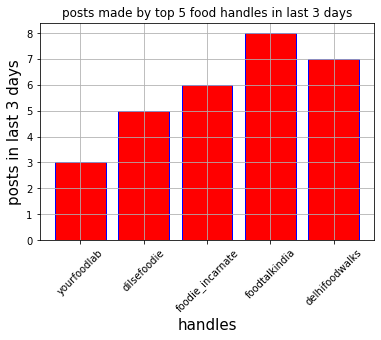

In [340]:
# 1.3 plotting

x = []
y = []

for key in page_posts_dict:
    x.append(key.split("/")[3])
    y.append(page_posts_dict[key])
    

## bar graph is chosen

plt.bar(x,y,color="red",edgecolor="blue")
plt.xticks(rotation=45)
plt.xlabel("handles", size=15)
plt.ylabel("posts in last 3 days", size=15)
plt.title("posts made by top 5 food handles in last 3 days")
plt.grid()
plt.show()

# Part-2

In [341]:
## 2.1 scraping content of the posts

# dictionary to store all the content of posts
page_posts_content_dict = {}

# list to store all hashtags
all_hashtags = []

for page in top_5_pages:
    
    bot.visit_page_by_url(page)
    
    posts_and_hashtags = bot.get_posts_content_incl_hashtags() # returns a 2 element list of posts and hashtags
    
    page_posts_content_dict[page] = posts_and_hashtags[0]
    all_hashtags.append(posts_and_hashtags[1])

In [342]:
#printing all post contents (top-10 posts for top-5 handles)

for key in page_posts_content_dict:
    
    print(page_posts_content_dict[key])
    print("\n----------------------------------------------------------------\n")

['Raj Kachori! New Recipe Video is out now on YouTube! Check it out now! It’s chaat day at YFL & I have prepped some delicious Raj kachori today. It’s a really amazing recipe to try at home & I am sure you guys will love it. I have also shared my chutney recipes so you can prepare all the components at home. Do try the recipe & let me know! I just suddenly remember how I used to love having raj kachori in my 10 grade tuition brakes just below my classes in Mumbai! Those were the days! Enjoy the recipe! Cheers! ....#recipe #kachori #rajkachori #streetfood #indiancuisine #foodporn #indianfood #foodphotography #kachorilove #sanjyotkeer #yourfoodlab #instadaily #foodie #mumbaistagram #mumbaifood', 'Mumbai style Veg Grill Sandwich by Chef @sanjyotkeerWhat’s up guys! Mumbai style Veg Grill Sandwich! It’s one of the most loved street foods of Mumbai & the most two important components are the chutney & the sandwich masala, I have shown you how you can prep these easily at home. Also usually t

In [343]:
## 2.2 creating frequency list for each hashtag

hashtags_dict = {}

for handles in all_hashtags:
    
    for posts in handles:
        
        for h in posts:
        
            if len(h)>0 and h[0] == "#":

                if h in hashtags_dict:
                    hashtags_dict[h]+=1

                else:
                    hashtags_dict[h]=1
                    
for key in hashtags_dict:
    print(key, hashtags_dict[key])

#recipe 5
#kachori 1
#rajkachori 1
#streetfood 12
#indiancuisine 6
#foodporn 12
#indianfood 14
#foodphotography 7
#kachorilove 1
#sanjyotkeer 8
#yourfoodlab 8
#instadaily 6
#foodie 8
#mumbaistagram 1
#mumbaifood 2
#recipes 5
#recipeoftheday 4
#sandwich 2
#sandwichesofinstagram 2
#sandwichlover 2
#cheese 2
#cheesesandwich 2
#grilledsandwich 2
#vegetarian 2
#rice 1
#ricelover 1
#homemade 3
#sheekh 1
#kabab 1
#video 1
#mumbaistreetfood 4
#achaar 2
#mango 2
#mangoseason 4
#mangorecipe 2
#nostalgia 2
#oldrecipes 2
#streetfoodindia 6
#mangoachar 2
#darkphotography 2
#moody 2
#throughyourlens 2
#burger 1
#burgerrecipe 1
#icetea 2
#mangomilkshake 2
#mangolover 2
#frooti 2
#mangolove 2
#dilsefoodie 5
#Dilsefoodie 5
#reels 5
#mix 1
#foodieincarnate 10
#waheguru 1
#satnamwaheguru 1
#gurudwara 1
#banglasahib 1
#langar 1
#banglasahibgurudwara 1
#delhi 6
#delhifoodie 5
#sikhism 1
#newdelhi 6
#sodelhi 6
#foodtalkindia 6
#travelgram 1
#kolkata 1
#sokolkata 1
#kolkatadiaries 1
#kolkata_igers 1
#kolkata

In [350]:
## 2.3 converting into a csv file

two_d_list = []

for key in hashtags_dict:
    two_d_list.append([key, hashtags_dict[key]])

# storing in pandas DataFrame then later saving as csv
df = pd.DataFrame(two_d_list, columns = ["Hashtag", "Frequency"])

## sort values by frequency
df.sort_values("Frequency", ascending=False, ignore_index=True, inplace=True)

## save to a csv file
df.to_csv("hashtag_freq.csv", index=False)

In [345]:
## 2.4 printing most popular hashtags

for row in df.values:
    
    print(row[0], row[1])

#indianfood 14
#delhifood 12
#streetfood 12
#foodporn 12
#foodieincarnate 10
#foodie 8
#sanjyotkeer 8
#yourfoodlab 8
#delhihomefood 7
#homechef 7
#foodofdelhi 7
#delhicommunityandfoodstories 7
#delhicommunity 7
#eatwithanubhav 7
#cfs 7
#communityandfoodstories 7
#walkwithanubhav 7
#localfood 7
#foodculture 7
#dfwindelhi 7
#regionalfood 7
#foodphotography 7
#regionalcuisine 7
#sodelhi 6
#instadaily 6
#indiancuisine 6
#indianfoodbloggers 6
#streetfoodindia 6
#delhi 6
#newdelhi 6
#foodtalkindia 6
#reels 5
#delhifoodie 5
#recipe 5
#foodblogger 5
#delhigram 5
#desikhana 5
#dilsefoodie 5
#recipes 5
#Dilsefoodie 5
#delhistreetfood 4
#reelitfeelit 4
#recipeoftheday 4
#mumbaistreetfood 4
#mangoseason 4
#foodpornshare 3
#foodgram 3
#reelsinstagram 3
#himachalifood 3
#himachali 3
#delhifoodblogger 3
#haryanvifood 3
#foodgasm 3
#SetTheBar 3
#haryanvi 3
#foodlover 3
#haryanvicuisine 3
#foodiesofinstagram 3
#indianfoodie 3
#indianfoodblogger 3
#homemade 3
#mumbai 3
#reelkarofeelkaro 3
#indianstreetf

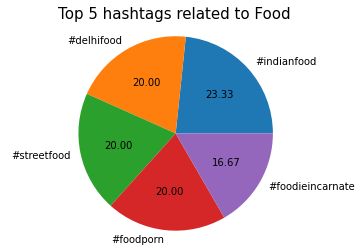

In [346]:
## 2.5 pie chart of top hashtags

y = df["Frequency"][:5]
x = df["Hashtag"][:5]

plt.pie(y, labels=x, autopct="%.2f")
plt.axis("equal")
plt.title("Top 5 hashtags related to Food", size=15)
plt.show()

# Part-3

In [347]:
## 3.1 and 3.2 finding average likes for the top 5 handles (both are done in 1 go)

page_average_likes_dict = {}

for page in top_5_pages:
    
    bot.visit_page_by_url(page) 
    page_average_likes_dict[page] = bot.get_avg_likes()

page_average_likes_dict

{'https://www.instagram.com/yourfoodlab/': 30844.7,
 'https://www.instagram.com/dilsefoodie/': 9148.8,
 'https://www.instagram.com/foodie_incarnate/': 24740.6,
 'https://www.instagram.com/foodtalkindia/': 971.6,
 'https://www.instagram.com/delhifoodwalks/': 979.9}

In [348]:
## 3.3 divide followers by average likes to get avg FOLLOWER : LIKE ratio

## note: likes are extracted differently in case of a reel

avg_follower_like_ratio = {}

for key in page_average_likes_dict:
    
    avg_follower_like_ratio[key] = page_follower_dict[key]/page_average_likes_dict[key]
    
for key in avg_follower_like_ratio:
    
    print(key.split("/")[3], avg_follower_like_ratio[key])

yourfoodlab 55.39327664071947
dilsefoodie 85.81037950332285
foodie_incarnate 17.125857901586865
foodtalkindia 313.87608069164264
delhifoodwalks 147.93958567200735


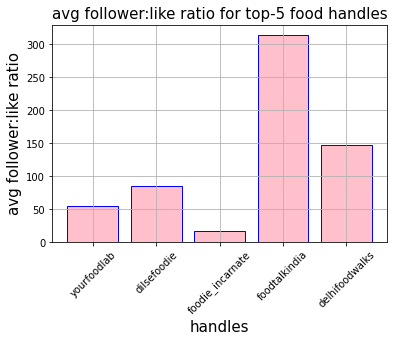

In [349]:
## 3.4 plotting bar graph

x = [key.split("/")[3] for key in avg_follower_like_ratio]
y = [avg_follower_like_ratio[key] for key in avg_follower_like_ratio]

plt.bar(x,y,color="pink",edgecolor="blue")
plt.grid()
plt.xticks(rotation=45)
plt.xlabel("handles", size=15)
plt.ylabel("avg follower:like ratio", size=15)
plt.title("avg follower:like ratio for top-5 food handles", size=15)
plt.show()

# Thank you for your time and efforts :)